# Modelagem 

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer

# 0. Carregamento dos dados
# Certifique-se de que o arquivo está na mesma pasta do seu notebook
df_Base = pd.read_csv('../data/df_Base_final.csv')


In [6]:

# 1. Preparação das Variáveis Alvo (Pedras-Conceito)
def definir_pedra(inde):
    if inde < 6.1: return 'Quartzo'
    elif inde < 7.2: return 'Ágata'
    elif inde < 8.2: return 'Ametista'
    else: return 'Topázio'

# Criando o target baseado no INDE
df_Base['Pedra_Conceito'] = df_Base['INDE'].apply(definir_pedra)


In [8]:

# 2. Engenharia de Recursos (Features)
# Transformando DEFA em categoria numérica (essencial para o modelo)
df_Base['Status_DEFA'] = df_Base['DEFA'].apply(
    lambda x: 0 if x < 0 else (1 if x == 0 else 2) # 0:Atrasado, 1:No Prazo, 2:Adiantado
)

# Selecionando as colunas preditoras
features = ['IAN', 'IDA', 'IEG', 'IAA', 'IPS', 'IPP', 'IPV', 'FASE', 'Status_DEFA']
X = df_Base[features]
y = df_Base['Pedra_Conceito']


In [9]:

# 3. Tratamento de dados faltantes (Imputação pela mediana)
# Isso resolve os problemas de NaN que vimos nos indicadores IDA, IEG e IAA
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)


In [10]:

# 4. Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [11]:

# 5. Treinamento do Modelo Random Forest
modelo_escola = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_escola.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [12]:

# 6. Avaliação
y_pred = modelo_escola.predict(X_test)
print(f"Acurácia do Modelo: {accuracy_score(y_test, y_pred):.2%}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Acurácia do Modelo: 88.48%

Relatório de Classificação:
               precision    recall  f1-score   support

    Ametista       0.87      0.93      0.90       255
     Quartzo       0.95      0.85      0.89        84
     Topázio       0.96      0.84      0.90        97
       Ágata       0.84      0.87      0.85       163

    accuracy                           0.88       599
   macro avg       0.91      0.87      0.88       599
weighted avg       0.89      0.88      0.88       599



In [13]:

# 7. Identificação de Alunos em Risco para 2025
# Predição para toda a base para gerar a lista de intervenção
df_Base['Predicao_2025'] = modelo_escola.predict(X_imputed)
alunos_em_risco = df_Base[df_Base['Predicao_2025'].isin(['Quartzo', 'Ágata'])]


In [14]:

# 8. Importância das Variáveis
importancias = pd.DataFrame({'Feature': features, 'Importancia': modelo_escola.feature_importances_})
print("\nPrincipais Fatores de Decisão do Modelo:")
print(importancias.sort_values(by='Importancia', ascending=False))


Principais Fatores de Decisão do Modelo:
       Feature  Importancia
1          IDA     0.261672
2          IEG     0.196433
6          IPV     0.164681
3          IAA     0.114782
4          IPS     0.079742
5          IPP     0.065094
0          IAN     0.045425
8  Status_DEFA     0.045175
7         FASE     0.026995


## Quais indicadores mais influenciam o Risco Acadêmico?

C:\Users\mtmal\AppData\Local\Temp\ipykernel_7428\1390987156.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


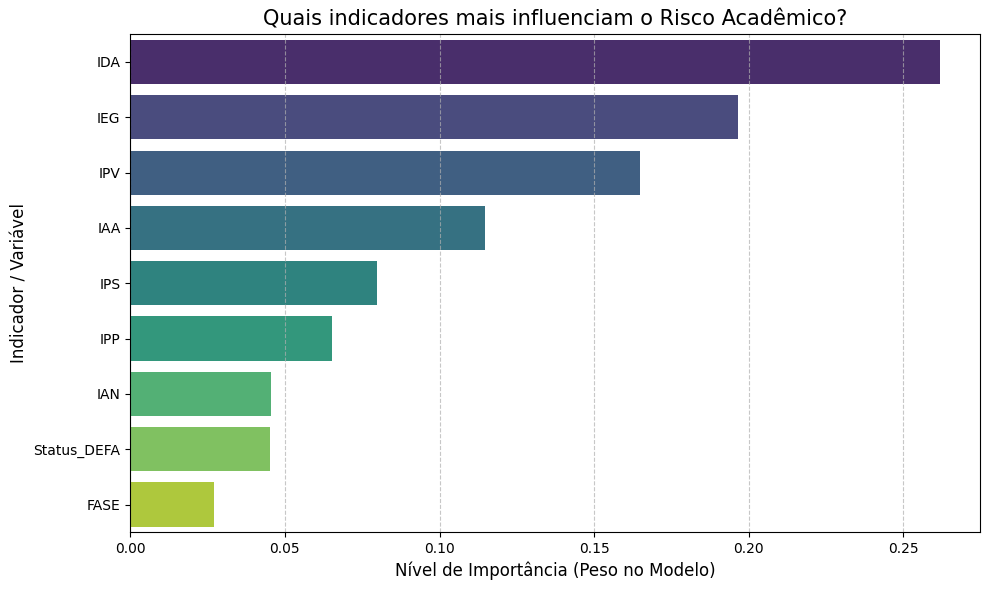

     Indicador  Importancia
1          IDA     0.261672
2          IEG     0.196433
6          IPV     0.164681
3          IAA     0.114782
4          IPS     0.079742
5          IPP     0.065094
0          IAN     0.045425
8  Status_DEFA     0.045175
7         FASE     0.026995


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar os dados de importância
importancias_df = pd.DataFrame({
    'Indicador': features, 
    'Importancia': modelo_escola.feature_importances_
})

# Ordenar para o gráfico ficar mais legível
importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)

# 2. Criar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importancia', 
    y='Indicador', 
    data=importancias_df, 
    palette='viridis'
)

# 3. Adicionar títulos e rótulos
plt.title('Quais indicadores mais influenciam o Risco Acadêmico?', fontsize=15)
plt.xlabel('Nível de Importância (Peso no Modelo)', fontsize=12)
plt.ylabel('Indicador / Variável', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 4. Salvar e exibir
plt.tight_layout()
plt.savefig('importancia_indicadores_2025.png')
plt.show()

# Exibir os valores numéricos exatos para o relatório
print(importancias_df)

## Matriz de Confusão

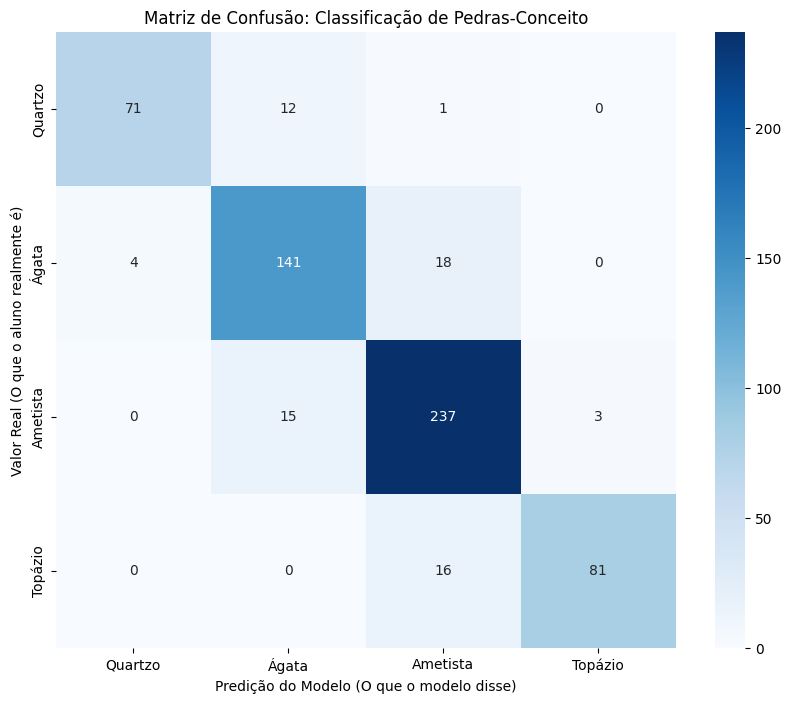

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Definir a ordem das categorias para que o gráfico faça sentido (do risco à excelência)
ordem_pedras = ['Quartzo', 'Ágata', 'Ametista', 'Topázio']

# 2. Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=ordem_pedras)

# 3. Plotar a matriz usando o Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ordem_pedras, 
            yticklabels=ordem_pedras)

plt.title('Matriz de Confusão: Classificação de Pedras-Conceito')
plt.xlabel('Predição do Modelo (O que o modelo disse)')
plt.ylabel('Valor Real (O que o aluno realmente é)')
plt.show()

O modelo obteve uma acurácia de **88,48%** indica que o modelo é confiável o suficiente para guiar decisões pedagógicas, mas possui uma margem de erro que respeita as nuances humanas que a matemática nem sempre captura.

### 1. Desempenho por "Pedra-Conceito"

* **Quartzo (Alta Precisão - 0.95):** O modelo é extremamente assertivo ao dizer que um aluno é **Quartzo**. Se o modelo classificou alguém aqui, há 95% de chance de ele realmente estar no nível de risco mais crítico.
* **Ametista (Alto Recall - 0.93):** O modelo consegue identificar quase todos os alunos que pertencem a esta faixa (a maior da escola). Isso é ótimo para manter a estabilidade da maioria dos estudantes.
* **Ágata (O ponto de atenção):** Tem o menor f1-score (**0.85**). Isso acontece porque a faixa Ágata é uma zona de transição entre o risco (Quartzo) e a estabilidade (Ametista), sendo a área onde o modelo tem mais dúvidas.

### 2. Oportunidade de Intervenção

Observe o **Recall** do **Topázio (0.84)** e do **Quartzo (0.85)**.

* Isso significa que cerca de 15% a 16% dos alunos que *realmente* são dessas categorias foram classificados em faixas vizinhas pelo modelo.
* **Na prática:** Pode haver alunos com potencial para serem Topázio que estão sendo "subestimados" pelo modelo, ou alunos em risco Quartzo que o modelo ainda vê como Ágata.

---

### Diagnóstico para a Coordenação Pedagógica

| Métrica | Valor | Impacto na Escola |
| --- | --- | --- |
| **Acurácia Global** | **88,5%** | O modelo acerta a classificação de quase 9 em cada 10 alunos. |
| **Precisão Quartzo** | **95%** | Erro quase zero ao apontar quem precisa de intervenção urgente. |
| **Recall Ametista** | **93%** | Garantia de que a maioria está sendo monitorada corretamente. |



Exportar o modelo para o arquivo joblib


In [ ]:
import joblib

# Definindo o pacote de exportação
export_data = {
    'modelo': modelo_escola,
    'imputer': imputer,
    'features': features,
    'classes': ordem_pedras # A ordem das pedras-conceito definida na matriz
}

# Salvando em um arquivo .pkl
joblib.dump(export_data, '../modelo/modelo_pedra_conceito_v1.pkl')
print("Modelo e componentes exportados com sucesso!")

Modelo e componentes exportados com sucesso!
